In [1]:
import scipy.io
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
from PIL import Image
import glob
import math
from sklearn.decomposition import PCA
import torchvision.transforms.functional as TF
import seaborn as sb
import gc
import os
import struct
from IPython.display import HTML
import umap
import plotly.express as px

from maps_helper import *
from data_imports import *
from retina_lgn import *
from training_loop import *
from analysis import *
import config

%load_ext autoreload
%autoreload 2
#%matplotlib widget
#%reload_ext autoreload

/home/nicolamendini/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nicolamendini/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nicolamendini/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaD

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
map size:  114


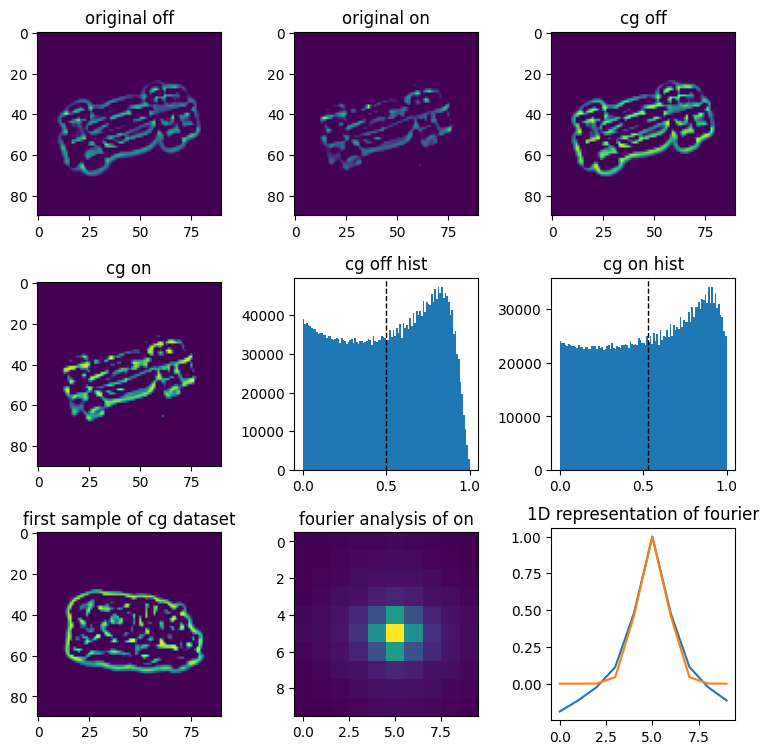

cosine similarity: tensor(0.9688, device='cuda:0')
std:  0.2867567837238312
kurtosis:  tensor(0.1949) tensor(0.1682)
combined (std/rmse):  tensor(0.2391, device='cuda:0')
torch.Size([4050, 2, 90, 90])
tensor(0.3429, device='cuda:0')


In [2]:
#X = import_fruit()

c = 3
X = import_norb().type(torch.float16).cuda()[:,:,:162,0,c:-c,c:-c]
input_size = X.shape[-1]
X = X.reshape(-1,1,input_size, input_size)
#X = F.pad(X, (input_size-1,0,input_size-1,0), mode='reflect')
input_size = X.shape[-1]

X, X_orig, X_mask = retina_lgn(
    X,
    config.RET_LOG_STD,
    config.LGN_LOG_STD,
    config.HARDGC,
    config.RF_STD,
    config.CG_EPS,
    config.CG_SATURATION,
    config.LGN_ITERS
)

X = X.float()
print('map size: ', config.GRID_SIZE)

plot_input_stats(X, X_orig, X_mask, 9)

print((X[X>0]**2).mean())

In [3]:
sim_data = torch.load('sim_data/linear_stability/sim_data.pt')
affinities = sim_data['affinities']
stability = sim_data['stability']

In [4]:
scalevals = torch.linspace(0,36,10)
torch.sqrt(scalevals)

tensor([0.0000, 2.0000, 2.8284, 3.4641, 4.0000, 4.4721, 4.8990, 5.2915, 5.6569,
        6.0000])

tensor([[[0.9937, 1.0000, 0.9995, 0.9995, 0.9989, 0.9991, 0.9993, 0.9999,
          0.9999],
         [0.4822, 0.8612, 0.9825, 0.9849, 0.9943, 0.9977, 0.9974, 0.9983,
          0.9999],
         [0.4277, 0.8116, 0.9536, 0.9520, 0.9758, 0.9912, 0.9925, 0.9964,
          0.9969],
         [0.4201, 0.7963, 0.9272, 0.9236, 0.9573, 0.9785, 0.9787, 0.9900,
          0.9911],
         [0.4126, 0.7769, 0.9190, 0.9025, 0.9357, 0.9669, 0.9691, 0.9817,
          0.9811],
         [0.4055, 0.7625, 0.9052, 0.8926, 0.9205, 0.9545, 0.9494, 0.9702,
          0.9697],
         [0.4016, 0.7614, 0.8941, 0.8800, 0.9046, 0.9424, 0.9395, 0.9584,
          0.9625],
         [0.4018, 0.7559, 0.8890, 0.8694, 0.8979, 0.9336, 0.9325, 0.9559,
          0.9470],
         [0.3982, 0.7568, 0.8844, 0.8662, 0.8963, 0.9251, 0.9204, 0.9415,
          0.9400]]])

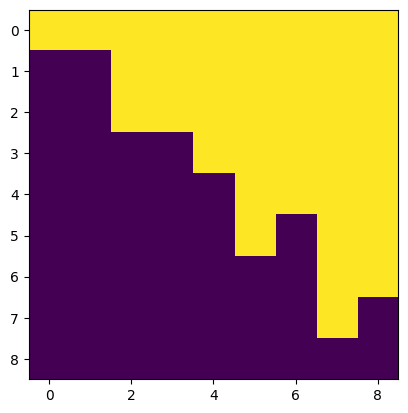

In [30]:
plt.imshow(stability[0]>.95)
stability

tensor([[0, 2, 3, 4, 5, 5, 7, 7, 0]])


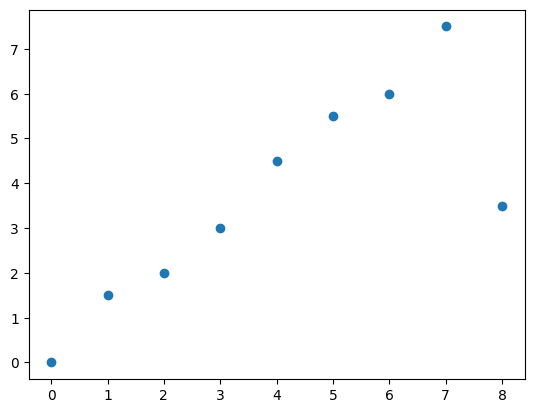

In [35]:
target_lines = [.95]

for i in target_lines:
    
    low_bound = stability - i
    low_bound[low_bound<0] = 1.1
    upp_bound = i - stability
    upp_bound[upp_bound<0] = 1.1
    
    low_idx = low_bound.min(2)[1]
    upp_idx = upp_bound.min(2)[1]
    
    points = (low_idx + upp_idx)[0]/2
    
    print(low_idx)
    
    plt.scatter(range(9), points)
    

In [39]:
gc.collect()
config.RECOPRINT = False
config.PRINT = False
config.KEEP = True

if not config.LONGRUN_MODE:
    if config.KEEP or config.PRINT or config.RECOPRINT:
        model,stats = run(X, model, stats, eval_at_end=config.EVALUATE)
    else:
        stats = {}
        model = new_model(X)
        run(X, model, stats, eval_at_end=config.EVALUATE)

torch.Size([3364, 841]) torch.Size([3364, 84])


affinity: 0.551 reco: 0.000 ensemble: 0.000 avg act: 0.049 max: 0.928 threshs: 0.258 LR: -0.0013: : 1it [00:00, 76.24it/s]

torch.Size([3364, 841]) torch.Size([3364, 84])


final stats, affinity: 0.560 reco 0.000
avg_fixed noise:  tensor(nan)
avg noise:  tensor(nan)
avg corr noise:  tensor(nan)
avg sparsity:  tensor(0.9493)
avg RF sparsity:  tensor(nan)
mixed case:  tensor(nan)


In [36]:
model.inh_strength, model.exc_strength

(tensor(1.9044, device='cuda:0'), tensor(2.5092, device='cuda:0'))

torch.Size([3364, 841]) torch.Size([3364, 84])


0it [00:00, ?it/s]

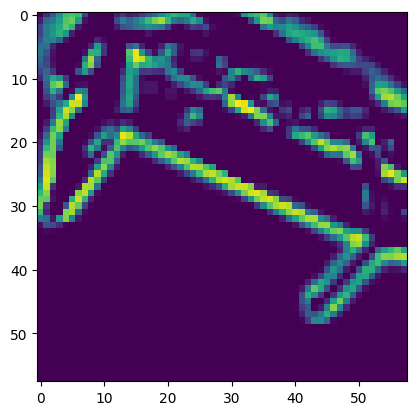

0it [00:00, ?it/s]

abort


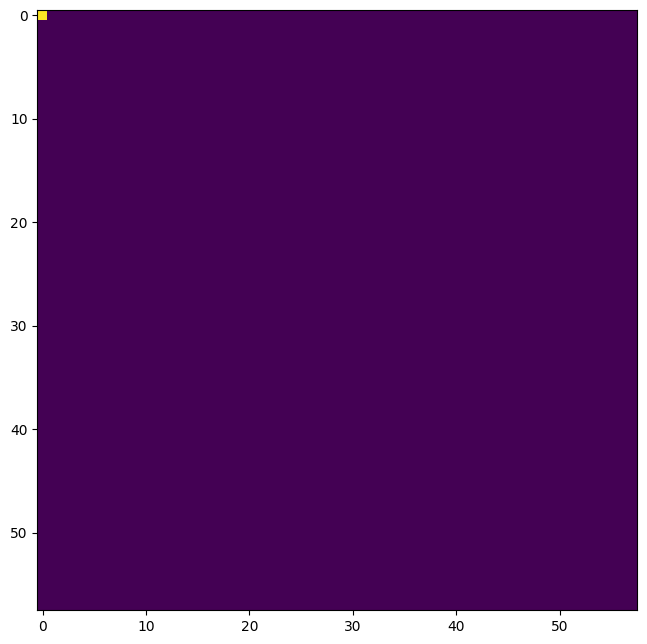

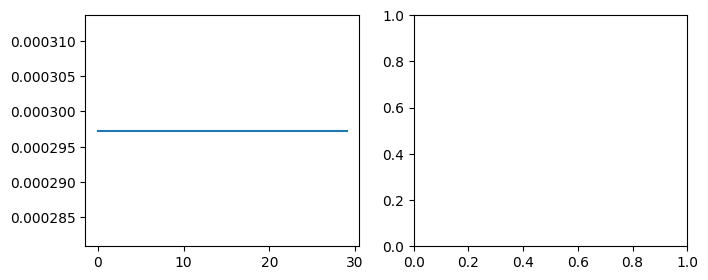

In [44]:
nim = None
if not config.LONGRUN_MODE:
    
    plt.clf()
    config.PRINT = True
    model, loss = run(X, model, stats, eval_at_end=False)
    array = model.lat_tracker.cpu()[:,0,0]
    # trick to normalise the cmap between 0-1
    array[:,0,0] = 1
    anim = animate(array, config.ITERS)
    anim = anim.to_jshtml()
    config.PRINT = False
    plt.show()
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.plot(array.mean([1,2]))
    plt.subplot(1,3,2)
    #plt.plot(model.time_trackers[0].cpu())
    #plt.subplot(1,3,3)
    #plt.plot(model.time_trackers[1].cpu())
    plt.show()
    
HTML(anim)

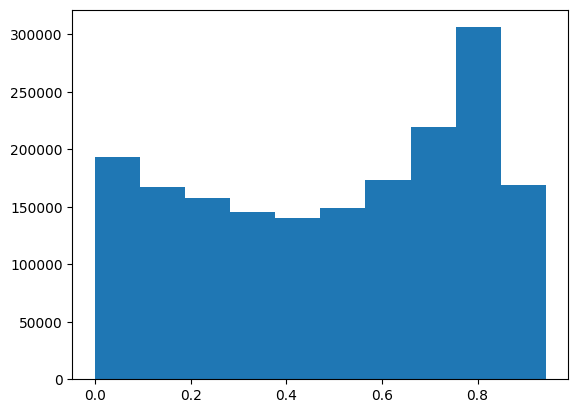

In [546]:
plt.hist(stats['lat_tracker'][stats['lat_tracker']>0].flatten().numpy())
plt.show()

In [444]:
angles = model.rfs.detach().cpu().view(-1,2,model.rf_units,model.rf_units)
print('mean magnitude: ', angles.mean())
angles_print_on = angles[:,0].view(config.GRID_SIZE, config.GRID_SIZE, model.rf_units, model.rf_units)
angles_print_on = angles_print_on.permute(0,2,1,3).reshape(config.GRID_SIZE*model.rf_units, config.GRID_SIZE*model.rf_units)
angles_print_off = angles[:,1].view(config.GRID_SIZE, config.GRID_SIZE, model.rf_units, model.rf_units)
angles_print_off = angles_print_off.permute(0,2,1,3).reshape(config.GRID_SIZE*model.rf_units, config.GRID_SIZE*model.rf_units)
angles.shape, angles_print_on.min(), angles_print_on.max(), angles_print_off.min(), angles_print_off.max()

mean magnitude:  tensor(0.1000)


(torch.Size([14400, 2, 21, 21]),
 tensor(0.0253),
 tensor(0.2524),
 tensor(0.0138),
 tensor(0.2952))

(tensor(0.2627), tensor(0.1868), tensor(0.0189), tensor(0.0943))

<Figure size 640x480 with 0 Axes>

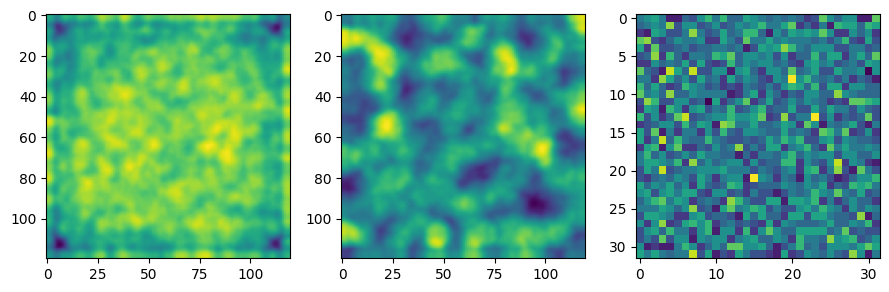

In [445]:
threshs = model.adathresh.cpu()[0,0].float()
acts = model.avg_acts.cpu()[0,0].float()

plt.clf()
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(threshs)
plt.subplot(1,3,2)
plt.imshow(acts)
plt.subplot(1,3,3)
plt.imshow(stats['fixation_map'])
plt.tight_layout()
threshs.max(), threshs.min(), acts.min(), acts.max()

plotting shape:  torch.Size([25, 120, 120])


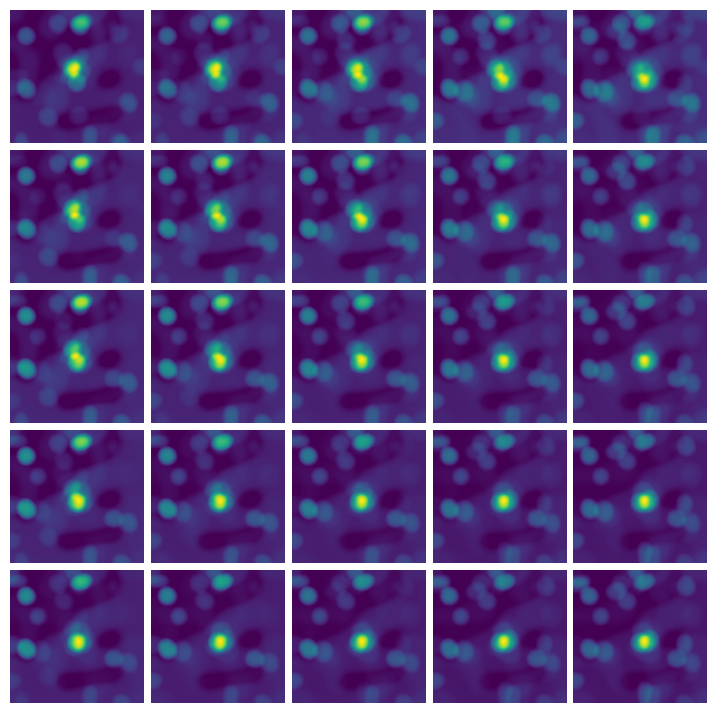

plotting shape:  torch.Size([25, 21, 21])


<Figure size 640x480 with 0 Axes>

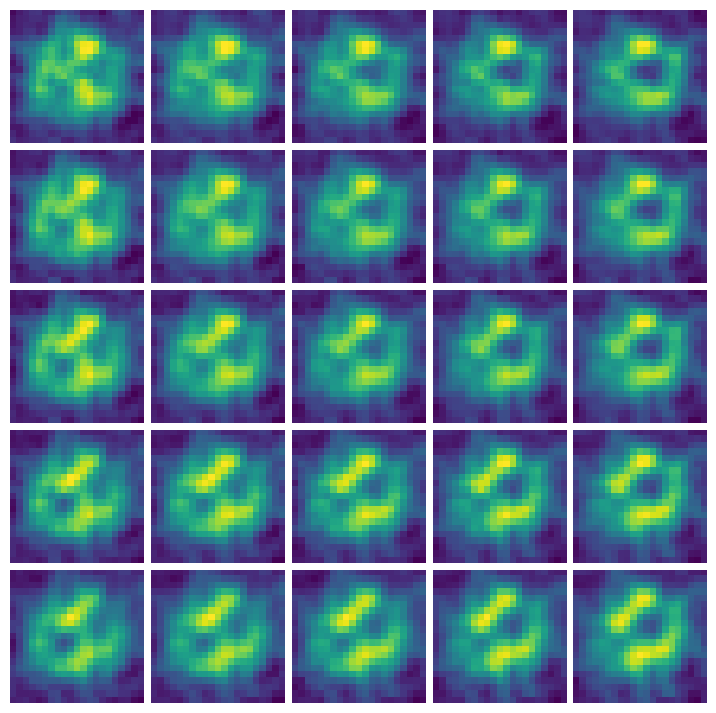

(tensor(0.1875), tensor(0.2952), tensor(0.0138))

<Figure size 640x480 with 0 Axes>

In [446]:
plot_grid(stats['global_corr'].view(-1, config.GRID_SIZE,config.GRID_SIZE).cpu(), config.CORR_SAMPLES, (9,9))
plt.tight_layout()
corr_angles = angles[:,0:1].view(config.GRID_SIZE,config.GRID_SIZE,model.rf_units,model.rf_units).float()
corr_angles = corr_angles[config.GRID_SIZE//2-config.CORR_SAMPLES//2:config.GRID_SIZE//2+config.CORR_SAMPLES//2+1,config.GRID_SIZE//2-config.CORR_SAMPLES//2:config.GRID_SIZE//2+config.CORR_SAMPLES//2+1]
plot_grid(corr_angles.cpu().reshape(-1, model.rf_units,model.rf_units), config.CORR_SAMPLES, (9,9))
plt.tight_layout()
corr_angles.max(), angles.max(), angles.min()

In [436]:
#masks = get_weight_masks([0.9], model.rfs.detach().shape)
#print(masks.shape)
#masked = torch.relu(model.rfs.detach().cpu()-0.08) * masks[0]
#plt.imshow(masked[2790].view(2,21,21)[0])

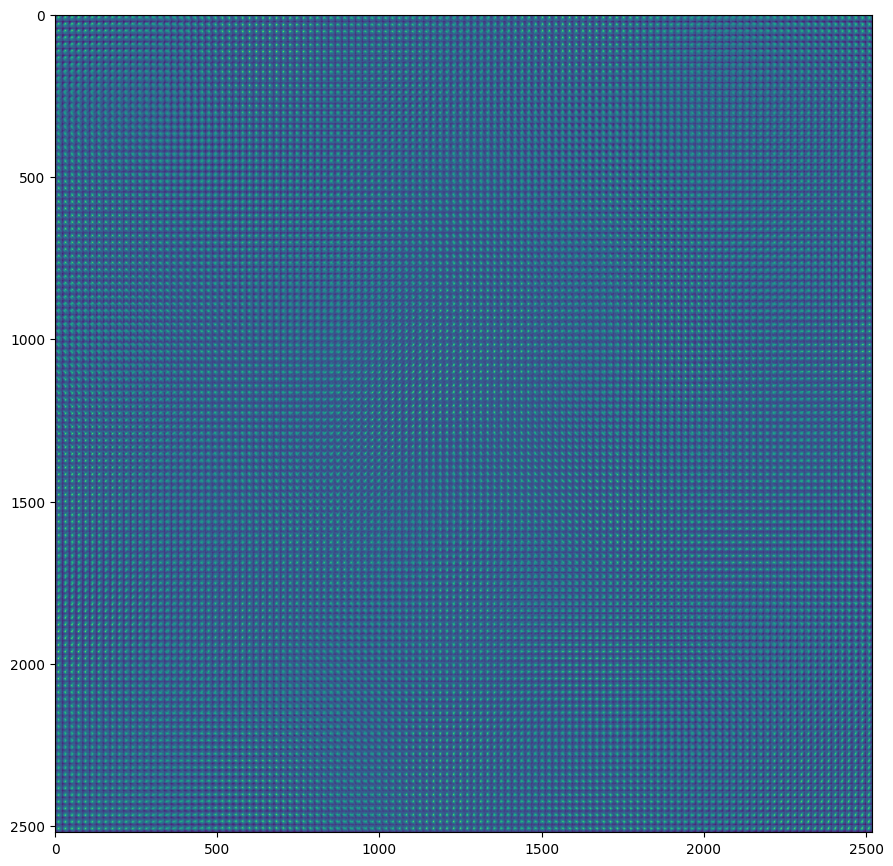

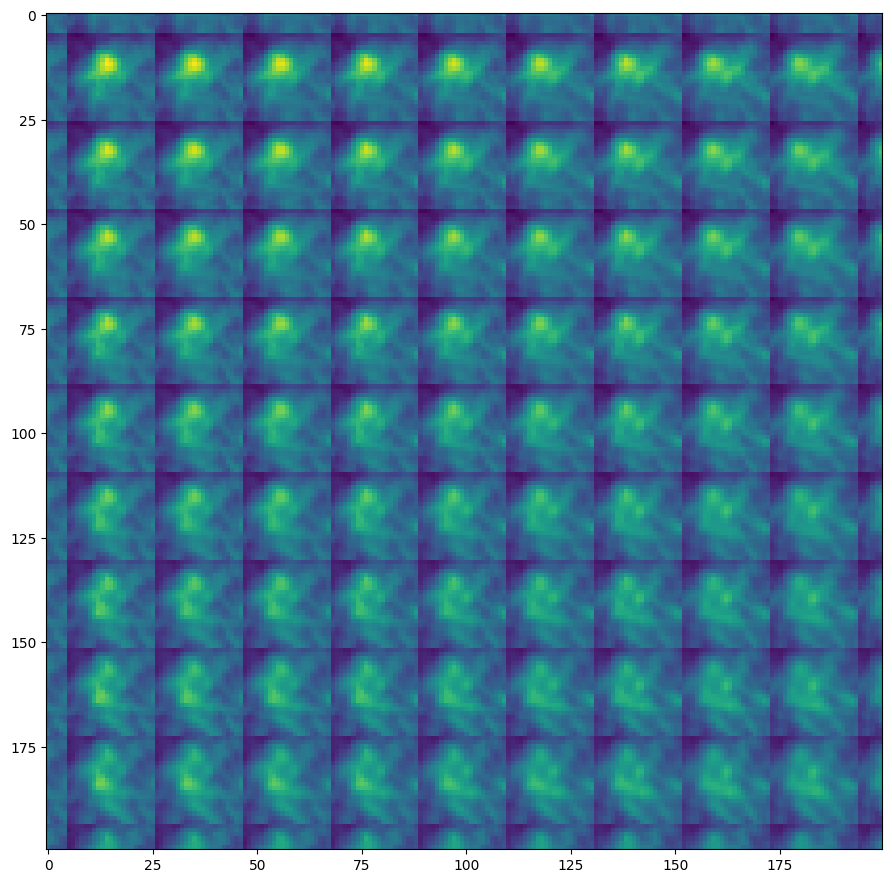

In [437]:
START_RF = 100

plt.figure(figsize=(9,9))
plt.imshow(angles_print_off.float())
plt.tight_layout()
plt.show()
plt.figure(figsize=(9,9))
plt.imshow(angles_print_off[START_RF:START_RF+200,START_RF:START_RF+200].float())
plt.tight_layout()
plt.show()

max and min magnitudes:  tensor(0.9537) tensor(0.8494)
plotting shape:  torch.Size([100, 57, 57])


<Figure size 640x480 with 0 Axes>

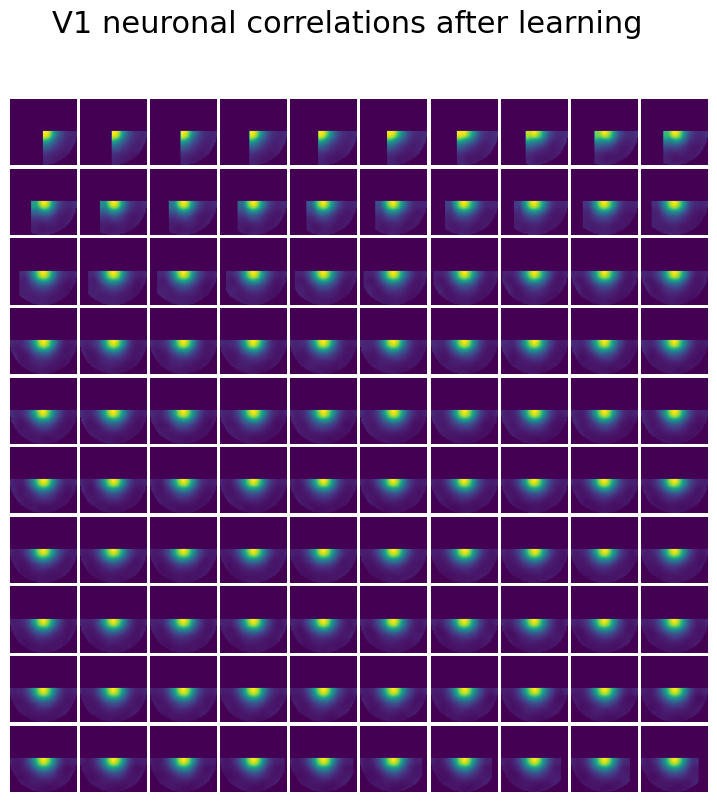

In [459]:
N_SAMPS = 10
START = 0

w = (model.get_lat_weights() * model.lri_cutoff).cpu().float()

print('max and min magnitudes: ', w.sum(1).max(), w.sum(1).min())

lneg_w = w
lneg_w /= (lneg_w.sum(1, keepdim=True))
w_plot = w.view(-1,model.lri_units,model.lri_units).cpu()[START:START+N_SAMPS**2]

plt.tight_layout()
plot_grid(w_plot, N_SAMPS, (9,9), 'V1 neuronal correlations after learning')

In [416]:
#masks = get_weight_masks([0.9], model.lat_weights.detach().shape)
#print(masks.shape)
#masked = torch.relu(model.lat_weights.detach().cpu()-0.05) * masks[0]
#plt.imshow(masked[2790].view(41,41), cmap=cm.Greys)

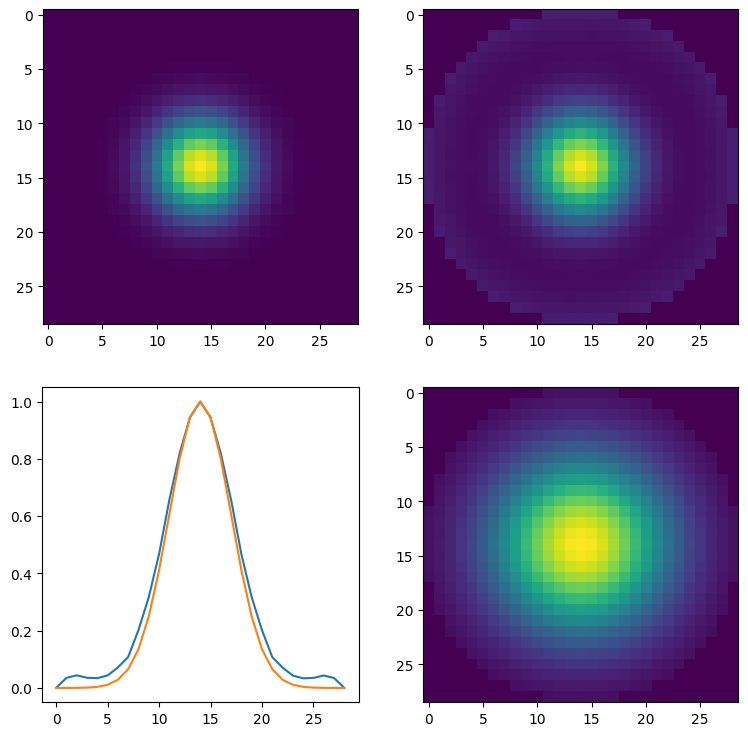

In [417]:
A = 25
GFIT = 2 / config.DILATION * config.EXC_STD

w_borderless = w.float().view(config.GRID_SIZE,config.GRID_SIZE,-1,1).detach().cpu()
#w_borderless = w_borderless[config.INH_SCALE//2:-config.INH_SCALE//2,config.INH_SCALE//2:-config.INH_SCALE//2]
w_mean = w_borderless.mean([0,1,3]).view(model.lri_units,model.lri_units)

sim = get_gaussian(model.lri_units, GFIT)[0,0] 
#sim = sim * model.lri_envelope.cpu().view(model.lri_units, model.lri_units)

gneg = model.lri_envelope.cpu().float()
fit = w_mean * (gneg.max()-gneg.view(1,1,model.lri_units,model.lri_units))

fit = fit.sum([0,1,3])
fit /= fit.max()

plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.imshow(sim)
plt.subplot(2,2,2)
plt.imshow(w_mean )

sim = sim.mean(-2)
sim -= sim.min()
sim /= sim.max()

w_mean = w_mean.sum(-1).cpu()
w_mean -= w_mean.min() 
w_mean /= w_mean.max()

plt.subplot(2,2,3)
plt.plot(w_mean)
plt.plot(sim)
#plt.plot(fit)

plt.subplot(2,2,4)
plt.imshow(gneg.view(1,1,model.lri_units,model.lri_units)[0,0])
plt.show()

(tensor(0., device='cuda:0'), tensor(3.1416, device='cuda:0'))

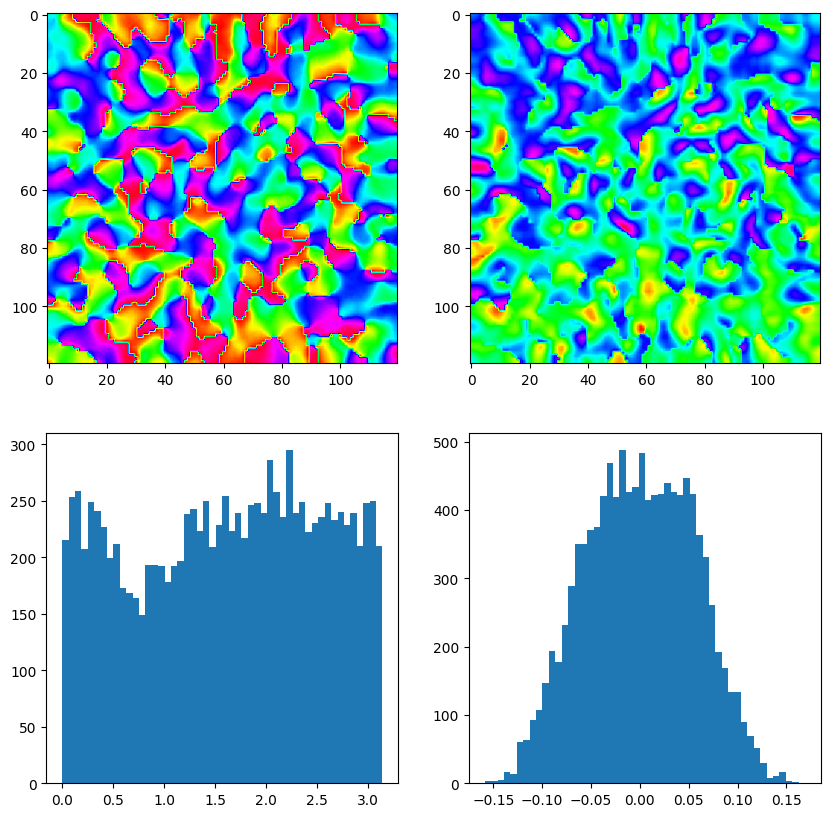

In [418]:
discreteness = 100
mask_out = True

orientations, phases = get_orientations(model,
    discreteness=discreteness,
    on_off_flag=True
)

ori_mask = torch.ones(orientations.shape).bool()
if mask_out:
    ori_mask = get_circle(orientations.shape[-1], orientations.shape[-1]/2)[0,0]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(orientations.cpu(), cmap='hsv')
plt.subplot(2,2,2)
plt.imshow(phases.cpu(), cmap='hsv')
plt.subplot(2,2,3)
plt.hist(orientations[ori_mask].flatten().cpu().numpy(), bins=discreteness//2)
plt.subplot(2,2,4)
plt.hist(phases[ori_mask].flatten().cpu().numpy(), bins=discreteness//2)
orientations.min(), orientations.max()

141

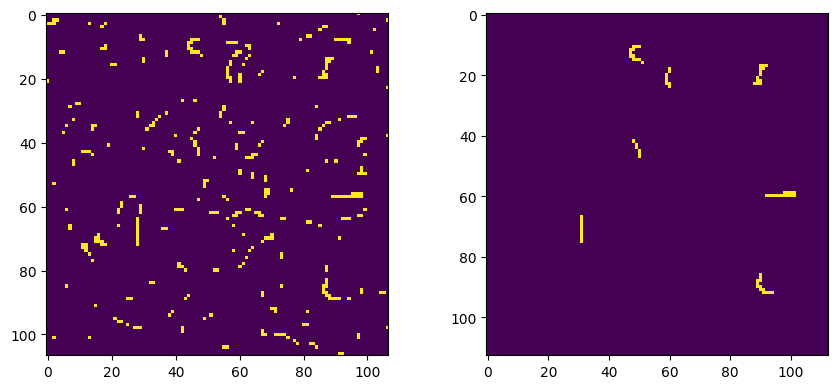

In [272]:
count, pinwheels, pinwheels_copy = count_pinwheels(orientations, config.MAPCHOP)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(pinwheels)
plt.subplot(1,2,2)
plt.imshow(pinwheels_copy)
plt.tight_layout()
count

tensor(216.7825) tensor(568.0938)


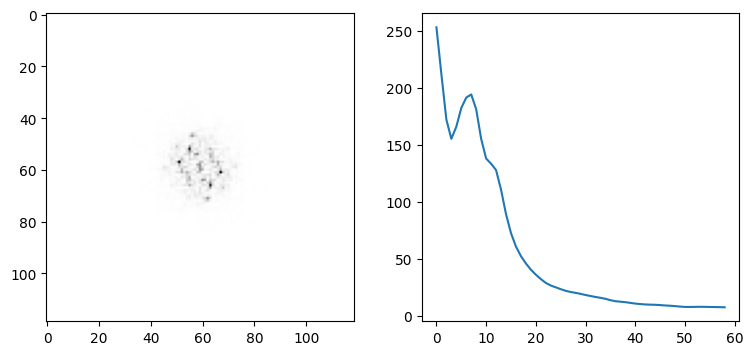

In [273]:
#orientations = F.pad(orientations, (30,30,30,30))
avg_peak, spectrum, avg_hist = get_typical_dist_fourier(
    orientations, 
    0, 
    mask=0, 
    smoothing_std=config.GRID_SIZE
)
ratio = count / (config.GRID_SIZE-config.MAPCHOP*2)**2 * avg_peak**2
print(avg_peak,ratio)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(spectrum**2, cmap='Greys')
plt.subplot(1,2,2)
plt.plot(avg_hist)
plt.show()

In [20]:
torch.save(model.state_dict(), './sim_data/model.pt')

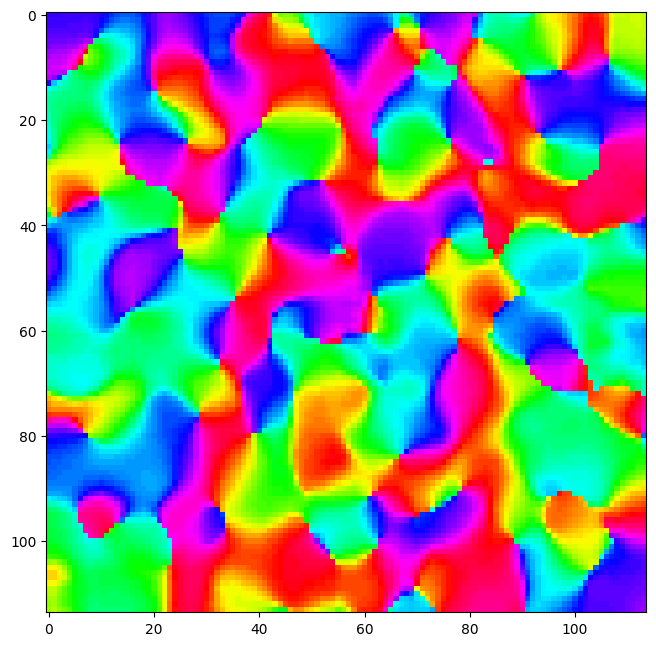

In [21]:
anim = animate(stats['map_tracker'], config.N_BATCHES//(config.STATS_FREQ*10), cmap='hsv')
HTML(anim.to_jshtml())

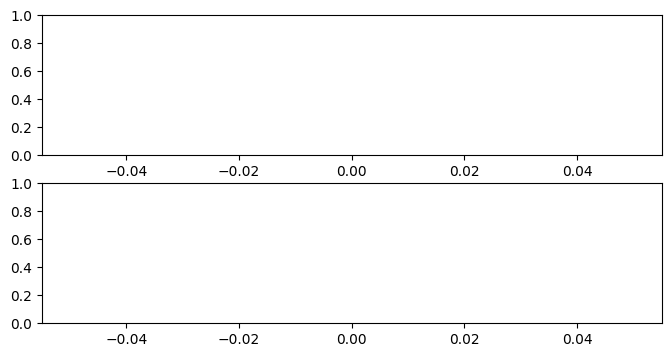

In [187]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.ylim(0,1)
plt.plot(stats['affinity_tracker'][stats['affinity_tracker']>0])
plt.subplot(2,1,2)
plt.ylim(0,1)
plt.plot(stats['reco_tracker'][stats['reco_tracker']>0])
plt.show()

In [188]:
#act_tiles = torch.load('act_tiles.pt')
act_tiles = split_activations(stats['lat_tracker'], 3, config.TARGET_ACT)
#act_tiles = act_tiles[:, torch.randperm(act_tiles.shape[1])]
print(act_tiles.shape)
act_size = int(np.sqrt(act_tiles.shape[-1]))
act_tiles.shape
act_tiles, pca, embedding = project_to_lower_dims(act_tiles, gridness_thresh=0, peak_spacing=7)
print(act_tiles.shape)

torch.Size([67700, 625])
torch.Size([67700, 625])


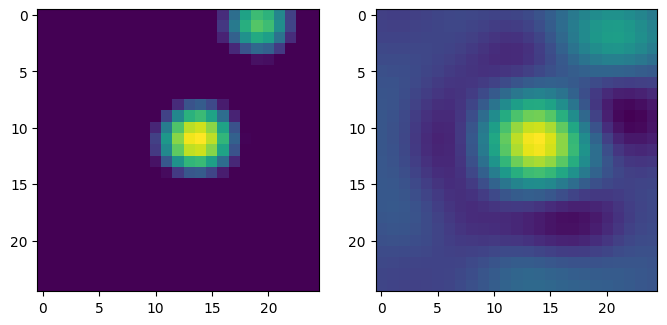

<Figure size 640x480 with 0 Axes>

In [189]:
draw_pca(pca, act_tiles, 8)
plt.tight_layout()

In [190]:
pca.explained_variance_ratio_

array([0.06617547, 0.06546975, 0.06029539, 0.05825386, 0.05192886,
       0.04076026, 0.04045562, 0.0346892 , 0.03425951, 0.03379532,
       0.03205917, 0.03015662, 0.02722362, 0.02612514, 0.02530309,
       0.02473707, 0.02148407, 0.02099142, 0.02095344, 0.01685686])

In [191]:
pca.explained_variance_ratio_

array([0.06617547, 0.06546975, 0.06029539, 0.05825386, 0.05192886,
       0.04076026, 0.04045562, 0.0346892 , 0.03425951, 0.03379532,
       0.03205917, 0.03015662, 0.02722362, 0.02612514, 0.02530309,
       0.02473707, 0.02148407, 0.02099142, 0.02095344, 0.01685686])

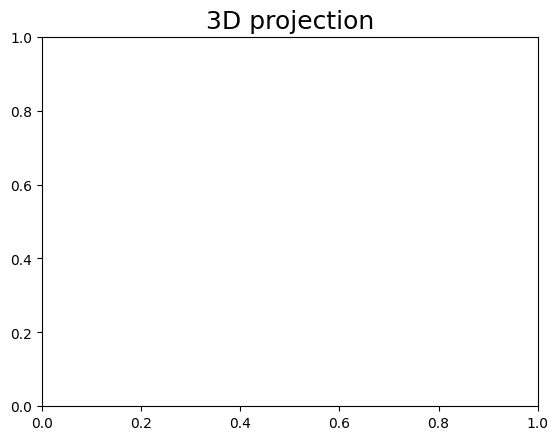

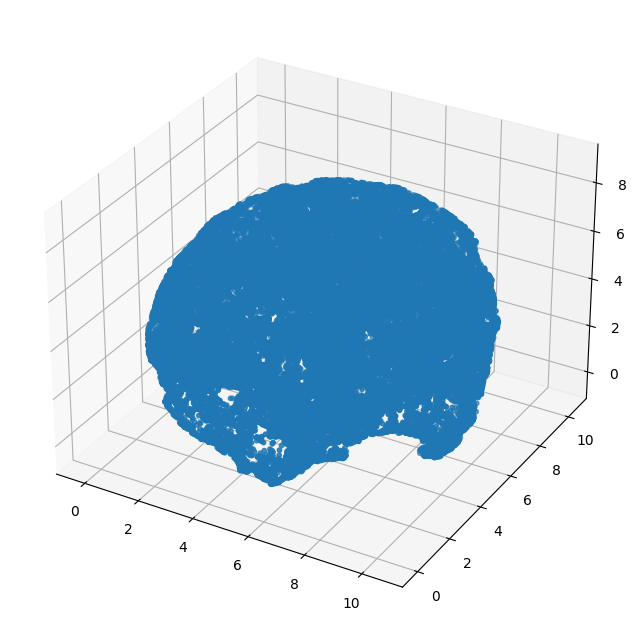

<Figure size 640x480 with 0 Axes>

In [192]:
draw_umap(embedding, 8)
plt.tight_layout()

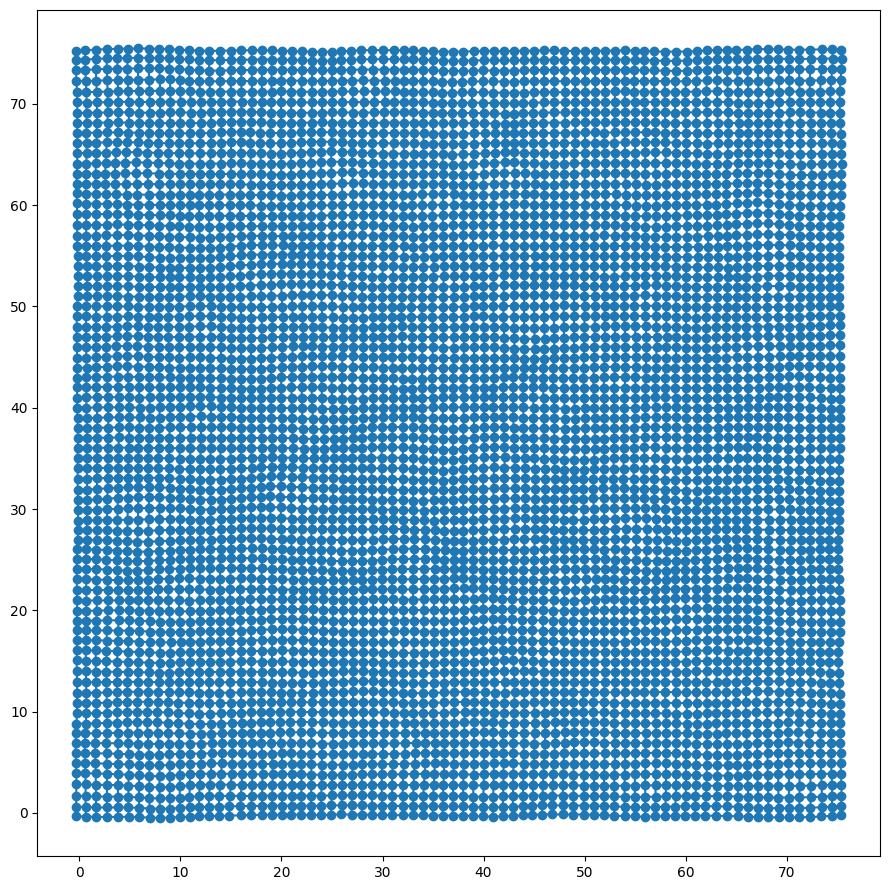

<Figure size 640x480 with 0 Axes>

In [193]:
plot_absolute_phases(model)
plt.tight_layout()